In [12]:
import os
from typing import Callable, Sequence, Tuple

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchmetrics import Dice
from torchmetrics.classification import BinaryJaccardIndex

from segmentation_models_pytorch import DeepLabV3Plus

In [3]:
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [5]:
MEAN = np.array([0.585, 0.466, 0.445])
STD = np.array([0.224, 0.208, 0.198])

In [6]:
class ImageDatasetForSegmentation(Dataset):
    def __init__(self, path: str, is_train: bool = True) -> None:
        super().__init__()

        self.resize = A.Resize(256, 256)
        self.transform = A.Compose([
            A.Normalize(mean=MEAN, std=STD),
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.Rotate(45, border_mode=cv2.BORDER_CONSTANT, value=0),
            ToTensorV2()
        ]) if is_train else A.Compose([
            A.Normalize(mean=MEAN, std=STD),
            ToTensorV2()
        ])

        self.images, self.masks = [], []
        
        for file in tqdm(os.listdir(f'{path}/images')):
            if not os.path.exists(f'{path}/masks/{file}'):
                continue

            image = cv2.cvtColor(cv2.imread(f'{path}/images/{file}'), cv2.COLOR_BGR2RGB)
            mask = cv2.imread(f'{path}/masks/{file}', cv2.IMREAD_GRAYSCALE) / 255

            resized = self.resize(image=image, mask=mask)

            self.images.append(resized['image']), self.masks.append(resized['mask'])

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        transformed = self.transform(image=self.images[index], mask=self.masks[index])
        return transformed['image'].float(), transformed['mask'].float()

    def __len__(self) -> int:
        return len(self.images)

In [7]:
denormalize = A.Normalize(
    mean=(-1) * MEAN / STD,
    std=1 / STD,
    max_pixel_value=1.0
)


def restore_image(image: torch.Tensor) -> np.ndarray:
    return denormalize(image=image.permute(1, 2, 0).numpy())['image']


def plot_image_grid(images: Sequence[torch.Tensor | np.ndarray]):
    fig, axs = plt.subplots(1, len(images), gridspec_kw={'wspace': 0, 'hspace': 0})

    for ax, image in zip(axs, images):
        ax.imshow(image)
        ax.axis('off')

In [8]:
train_dataset = ImageDatasetForSegmentation('data/train')
val_dataset = ImageDatasetForSegmentation('data/val', is_train=False)
test_dataset = ImageDatasetForSegmentation('data/test', is_train=False)

100%|██████████| 69/69 [00:08<00:00,  8.11it/s]


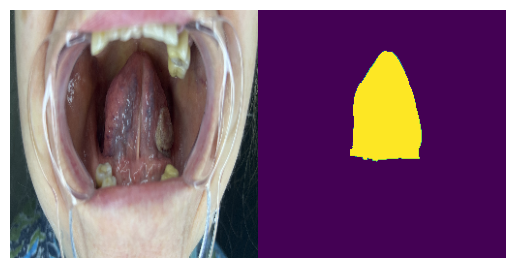

In [9]:
image, mask = train_dataset[141]
plot_image_grid([restore_image(image), mask])

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [13]:
def train(model: nn.Module,
          optimizer: torch.optim.Optimizer,
          loss_func: Callable,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          n_epochs: int = 50):
    train_loss_history, val_loss_history = [], []
    
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        
        for i, (images, true_masks) in enumerate(train_dataloader):
            images, true_masks = images.to(DEVICE), true_masks.to(DEVICE)

            optimizer.zero_grad()
            pred_masks = model(images).squeeze(dim=1)
            loss = loss_func(pred_masks, true_masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss_history.append(train_loss / (i + 1))

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for i, (images, true_masks) in enumerate(val_dataloader):
                images, true_masks = images.to(DEVICE), true_masks.to(DEVICE)
                pred_masks = model(images).squeeze(dim=1)
                loss = loss_func(pred_masks, true_masks)

                val_loss += loss.item()

            val_loss_history.append(val_loss / (i + 1))

        clear_output(wait=True)
        plt.plot(train_loss_history, label='train')
        plt.plot(val_loss_history, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Binary Cross Entropy')
        plt.legend()
        plt.show()

In [23]:
model = DeepLabV3Plus(encoder_name='resnet18', activation='sigmoid').to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_func = torch.nn.BCELoss()

In [ ]:
train(model, optimizer, loss_func, train_dataloader, val_dataloader)

In [25]:
def evaluate_metrics(model, dataloader: DataLoader, metrics: Callable) -> float:
    model.eval()

    t, p = [], []

    with torch.no_grad():
        for images, true_masks in dataloader:
            images = images.to(DEVICE)
            pred_masks = model(images).squeeze(dim=1).detach().cpu()

            t.append(true_masks)
            p.append(pred_masks)

    t = torch.cat(t)
    p = torch.cat(p)

    return [round(metric(p, t.int()).item(), 2) for metric in metrics]

In [26]:
evaluate_metrics(model, test_dataloader, [BinaryJaccardIndex(), Dice()])

[0.83, 0.91]